# ML Pipeline with PySpark

Putting theory into practice. 
Using some of the knowledge learned on the Machine Learning with Apache Spark Coursera IBM online course and more.

Data used:
- Market Watch S&P index historical data (Jan 3rd, 2023 - Jan 2nd, 2024) - https://www.marketwatch.com/investing/index/spx/download-data
- Yaho Finance S&P index historical data (Jan 3rd, 2023 - Jan 2nd, 2024) - https://finance.yahoo.com/quote/%5EGSPC/history/




Steps taken:
- Start PySpark session
- Import and transform Yahoo Finance Data
- Import and transform Market Watch Data
- Join and further transform Yahoo Finance and Market Watch Data
- Build ML Pipeline using:
	- VectorAssembler
	- StandardScaler
	- LinearRegression
- Evaluate the Model using three RegressionEvaluator (MSE, MAE, R2)
- Visualize data

## Start PySpark session

Importing libraries to start and run PySpark.

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("SP").getOrCreate()

In [3]:
spark

## Yahoo Finance Data

Importing the libraries used to transform the Yahoo Finance Data.

In [4]:
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
from pyspark.sql.types import LongType
from pyspark.sql.functions import col
from pyspark.sql.functions import desc
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import row_number

Importing Yahoo Finance Data and trasfering it to a format that can be used later in calculations and the ML Pipeline.

In [5]:
# Importing the Yahoo Finance Data to a Spark DataFrame:
df_yf = spark.read.csv("S&P_YF.csv", header=True, inferSchema=True)

In [6]:
# Analysing the data schema:
df_yf.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close*: string (nullable = true)
 |-- Adj Close**: string (nullable = true)
 |-- Volume: string (nullable = true)



In [7]:
# Analyzing the tabular form:
df_yf.show(5)

+---------+--------+--------+--------+--------+-----------+-------------+
|     Date|    Open|    High|     Low|  Close*|Adj Close**|       Volume|
+---------+--------+--------+--------+--------+-----------+-------------+
| 2-Jan-24|4,745.20|4,754.33|4,722.67|4,742.83|   4,742.83|3,743,050,000|
|29-Dec-23|4,782.88|4,788.43|4,751.99|4,769.83|   4,769.83|3,126,060,000|
|28-Dec-23|4,786.44|4,793.30|4,780.98|4,783.35|   4,783.35|2,698,860,000|
|27-Dec-23|4,773.45|4,785.39|4,768.90|4,781.58|   4,781.58|2,748,450,000|
|26-Dec-23|4,758.86|4,784.72|4,758.45|4,774.75|   4,774.75|2,513,910,000|
+---------+--------+--------+--------+--------+-----------+-------------+
only showing top 5 rows



In [8]:
# indexing the df_yf data --> creating df_yf_i data frame
windowSpec = Window.orderBy(monotonically_increasing_id().desc())
df_yf_i = df_yf.withColumn("IndexYF", row_number().over(windowSpec) - 1)

In [9]:
# adjusting some of the column titles:
df_yf_i = df_yf_i.withColumnRenamed("Close*", "Close")
df_yf_i = df_yf_i.drop("Adj Close**")
df_yf_i = df_yf_i.withColumnRenamed("Date", "Date_YF")

In [10]:
# Define the columns and their corresponding types
columns_to_modify = {
    "Open": FloatType(),
    "High": FloatType(),
    "Low": FloatType(),
    "Close": FloatType(),
    "Volume": LongType()
}

# Loop through the columns and apply the transformations
for col, dtype in columns_to_modify.items():
    df_yf_i = (df_yf_i
               .withColumn(col, regexp_replace(col, ",", "").cast(dtype))
               .withColumnRenamed(col, f"{col}_YF"))

In [11]:
# reorder the df_yf_i data
df_yf_i = df_yf_i.orderBy(desc("IndexYF"))

In [12]:
# looking at the df_yf_i data schema and table to see if we achieved the desired state
df_yf_i.show(5)
df_yf_i.printSchema()

+---------+-------+-------+-------+--------+----------+-------+
|  Date_YF|Open_YF|High_YF| Low_YF|Close_YF| Volume_YF|IndexYF|
+---------+-------+-------+-------+--------+----------+-------+
| 2-Jan-24| 4745.2|4754.33|4722.67| 4742.83|3743050000|    250|
|29-Dec-23|4782.88|4788.43|4751.99| 4769.83|3126060000|    249|
|28-Dec-23|4786.44| 4793.3|4780.98| 4783.35|2698860000|    248|
|27-Dec-23|4773.45|4785.39| 4768.9| 4781.58|2748450000|    247|
|26-Dec-23|4758.86|4784.72|4758.45| 4774.75|2513910000|    246|
+---------+-------+-------+-------+--------+----------+-------+
only showing top 5 rows

root
 |-- Date_YF: string (nullable = true)
 |-- Open_YF: float (nullable = true)
 |-- High_YF: float (nullable = true)
 |-- Low_YF: float (nullable = true)
 |-- Close_YF: float (nullable = true)
 |-- Volume_YF: long (nullable = true)
 |-- IndexYF: integer (nullable = false)



We can see that the relevant data in the DataFrame has the numberical data type that allows us to use it in calculations and in the ML pipeline. 

The 'Data_YF' date field's datatype has not been modified, as it will not be used in further analysis. We retain this date field for informational purposes until we join the two DataFrames (the Yahoo Finance and the Market Watch DataFrame).

## Market Watch Data

Importing additionaly libraries used to transform the Market Watch Data.

In [13]:
from pyspark.sql.functions import expr
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer

Importing Market Watch Data and transferring it to a format that can be used later in calculations and the ML Pipeline.

In [14]:
# Importing the Market Watch Data to a Spark DataFrame:
df_mw = spark.read.csv("S&P_MW.csv", header=True, inferSchema=True)

In [15]:
# Analysing the data schema
df_mw.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)



In [16]:
# Taking a look at the extract from the data frame:
df_mw.show(5)

+----------+--------+--------+--------+--------+
|      Date|    Open|    High|     Low|   Close|
+----------+--------+--------+--------+--------+
|01/02/2024|4,745.20|4,754.33|4,722.67|4,742.83|
|12/29/2023|4,782.88|4,788.43|4,751.99|4,769.83|
|12/28/2023|4,786.44|4,793.30|4,780.98|4,783.35|
|12/27/2023|4,773.45|4,785.39|4,768.90|4,781.58|
|12/26/2023|4,758.86|4,784.72|4,758.45|4,774.75|
+----------+--------+--------+--------+--------+
only showing top 5 rows



In [17]:
# renaming the columns to identify MW data and changing the data type where needed:

# Define the columns and their corresponding types
columns_to_modify = {
    "Open": FloatType(),
    "High": FloatType(),
    "Low": FloatType(),
    "Close": FloatType()
}

# Loop through the columns and apply the transformations
for col, dtype in columns_to_modify.items():
    df_mw = (df_mw
               .withColumn(col, regexp_replace(col, ",", "").cast(dtype))
               .withColumnRenamed(col, f"{col}_MW"))

In [18]:
# handle the date column separately:
df_mw = df_mw.withColumnRenamed("Date", "Date_MW")

In [19]:
# after changes on data it is good idea to look at the table and the schema
df_mw.show(5)
df_mw.printSchema()

+----------+-------+-------+-------+--------+
|   Date_MW|Open_MW|High_MW| Low_MW|Close_MW|
+----------+-------+-------+-------+--------+
|01/02/2024| 4745.2|4754.33|4722.67| 4742.83|
|12/29/2023|4782.88|4788.43|4751.99| 4769.83|
|12/28/2023|4786.44| 4793.3|4780.98| 4783.35|
|12/27/2023|4773.45|4785.39| 4768.9| 4781.58|
|12/26/2023|4758.86|4784.72|4758.45| 4774.75|
+----------+-------+-------+-------+--------+
only showing top 5 rows

root
 |-- Date_MW: string (nullable = true)
 |-- Open_MW: float (nullable = true)
 |-- High_MW: float (nullable = true)
 |-- Low_MW: float (nullable = true)
 |-- Close_MW: float (nullable = true)



In [20]:
# Reformat the date string from MM/dd/yyyy to dd/MM/yyyy
df_mw = df_mw.withColumn("Date_MW", expr("concat(substring(Date_MW, 7, 4), '/', substring(Date_MW, 1, 2), '/', substring(Date_MW, 4, 2))"))

In [21]:
df_mw.show(5)
df_mw.printSchema()

+----------+-------+-------+-------+--------+
|   Date_MW|Open_MW|High_MW| Low_MW|Close_MW|
+----------+-------+-------+-------+--------+
|2024/01/02| 4745.2|4754.33|4722.67| 4742.83|
|2023/12/29|4782.88|4788.43|4751.99| 4769.83|
|2023/12/28|4786.44| 4793.3|4780.98| 4783.35|
|2023/12/27|4773.45|4785.39| 4768.9| 4781.58|
|2023/12/26|4758.86|4784.72|4758.45| 4774.75|
+----------+-------+-------+-------+--------+
only showing top 5 rows

root
 |-- Date_MW: string (nullable = true)
 |-- Open_MW: float (nullable = true)
 |-- High_MW: float (nullable = true)
 |-- Low_MW: float (nullable = true)
 |-- Close_MW: float (nullable = true)



In [22]:
# Create a StringIndexer instance
indexer = StringIndexer(inputCol="Date_MW", outputCol="DateMWIndex")

# Fit the indexer to the DataFrame and transform it
df_mw_i = indexer.fit(df_mw).transform(df_mw)

In [23]:
df_mw_i.printSchema()

root
 |-- Date_MW: string (nullable = true)
 |-- Open_MW: float (nullable = true)
 |-- High_MW: float (nullable = true)
 |-- Low_MW: float (nullable = true)
 |-- Close_MW: float (nullable = true)
 |-- DateMWIndex: double (nullable = false)



In [24]:
from pyspark.sql.functions import col
df_mw_i = df_mw_i.withColumn("DateMWIndex", col("DateMWIndex").cast(IntegerType()))

In [25]:
# Show the DataFrame with the updated index column
df_mw_i.printSchema()
df_mw_i.show(5)

root
 |-- Date_MW: string (nullable = true)
 |-- Open_MW: float (nullable = true)
 |-- High_MW: float (nullable = true)
 |-- Low_MW: float (nullable = true)
 |-- Close_MW: float (nullable = true)
 |-- DateMWIndex: integer (nullable = true)

+----------+-------+-------+-------+--------+-----------+
|   Date_MW|Open_MW|High_MW| Low_MW|Close_MW|DateMWIndex|
+----------+-------+-------+-------+--------+-----------+
|2024/01/02| 4745.2|4754.33|4722.67| 4742.83|        250|
|2023/12/29|4782.88|4788.43|4751.99| 4769.83|        249|
|2023/12/28|4786.44| 4793.3|4780.98| 4783.35|        248|
|2023/12/27|4773.45|4785.39| 4768.9| 4781.58|        247|
|2023/12/26|4758.86|4784.72|4758.45| 4774.75|        246|
+----------+-------+-------+-------+--------+-----------+
only showing top 5 rows



In the Market Watch table, the date column is formatted as a string. For the Linear Regression model, only numerical values can be used. To address this, we have created a 'Date Index' column where the highest index (250) corresponds to the most recent date (2024/01/02), and the lowest index (0) corresponds to the earliest date (2023/01/03). This method, which involves replacing the date column with an index column, is quite straightforward. However, there are more complex methods that use the date column to track sample data over time. Our focus here is on transforming the data and creating a pipeline for the Machine Learning model.

## Join Yahoo Finance and Market Watch data

Importing additionaly libraries used to join the Yahoo Finance and the Market Watch DataFrame and the related calculations.

In [26]:
from pyspark.sql.functions import sum
from pyspark.sql.functions import round

The Yahoo Finance and the Market Watch cleaned data is going to be joined. Before joining the two data we take a look at the two dataframe to see if we are ready to join them:

1. Looking at the Yahoo Finance cleaned data

In [27]:
df_yf_i.printSchema()
df_yf_i.show(5)

root
 |-- Date_YF: string (nullable = true)
 |-- Open_YF: float (nullable = true)
 |-- High_YF: float (nullable = true)
 |-- Low_YF: float (nullable = true)
 |-- Close_YF: float (nullable = true)
 |-- Volume_YF: long (nullable = true)
 |-- IndexYF: integer (nullable = false)

+---------+-------+-------+-------+--------+----------+-------+
|  Date_YF|Open_YF|High_YF| Low_YF|Close_YF| Volume_YF|IndexYF|
+---------+-------+-------+-------+--------+----------+-------+
| 2-Jan-24| 4745.2|4754.33|4722.67| 4742.83|3743050000|    250|
|29-Dec-23|4782.88|4788.43|4751.99| 4769.83|3126060000|    249|
|28-Dec-23|4786.44| 4793.3|4780.98| 4783.35|2698860000|    248|
|27-Dec-23|4773.45|4785.39| 4768.9| 4781.58|2748450000|    247|
|26-Dec-23|4758.86|4784.72|4758.45| 4774.75|2513910000|    246|
+---------+-------+-------+-------+--------+----------+-------+
only showing top 5 rows



2. Looking at the Market Watch cleaned data

In [28]:
df_mw_i.printSchema()
df_mw_i.show(5)

root
 |-- Date_MW: string (nullable = true)
 |-- Open_MW: float (nullable = true)
 |-- High_MW: float (nullable = true)
 |-- Low_MW: float (nullable = true)
 |-- Close_MW: float (nullable = true)
 |-- DateMWIndex: integer (nullable = true)

+----------+-------+-------+-------+--------+-----------+
|   Date_MW|Open_MW|High_MW| Low_MW|Close_MW|DateMWIndex|
+----------+-------+-------+-------+--------+-----------+
|2024/01/02| 4745.2|4754.33|4722.67| 4742.83|        250|
|2023/12/29|4782.88|4788.43|4751.99| 4769.83|        249|
|2023/12/28|4786.44| 4793.3|4780.98| 4783.35|        248|
|2023/12/27|4773.45|4785.39| 4768.9| 4781.58|        247|
|2023/12/26|4758.86|4784.72|4758.45| 4774.75|        246|
+----------+-------+-------+-------+--------+-----------+
only showing top 5 rows



The data types for each table is as expected.

In [29]:
# joining the two cleaned dataframe
df_main = df_mw_i.join(df_yf_i, df_mw_i.DateMWIndex == df_yf_i.IndexYF, 'inner')

In [30]:
# taking a look at the joined data
df_main.show(5)

+----------+-------+-------+-------+--------+-----------+--------+-------+-------+-------+--------+----------+-------+
|   Date_MW|Open_MW|High_MW| Low_MW|Close_MW|DateMWIndex| Date_YF|Open_YF|High_YF| Low_YF|Close_YF| Volume_YF|IndexYF|
+----------+-------+-------+-------+--------+-----------+--------+-------+-------+-------+--------+----------+-------+
|2023/01/03|3853.29|3878.46|3794.33| 3824.14|          0|3-Jan-23|3853.29|3878.46|3794.33| 3824.14|3959140000|      0|
|2023/01/04|3840.36|3873.16|3815.77| 3852.97|          1|4-Jan-23|3840.36|3873.16|3815.77| 3852.97|4414080000|      1|
|2023/01/05|3839.74|3839.74|3802.42|  3808.1|          2|5-Jan-23|3839.74|3839.74|3802.42|  3808.1|3893450000|      2|
|2023/01/06|3823.37|3906.19|3809.56| 3895.08|          3|6-Jan-23|3823.37|3906.19|3809.56| 3895.08|3923560000|      3|
|2023/01/09|3910.82|3950.57|3890.42| 3892.09|          4|9-Jan-23|3910.82|3950.57|3890.42| 3892.09|4311770000|      4|
+----------+-------+-------+-------+--------+---

In [31]:
# check the Yahoo Finance and Market Watch Open, High, Low and Close values
df_main = df_main.withColumn("Open_Diff", col("Open_MW") - col("Open_YF"))
df_main = df_main.withColumn("High_Diff", col("High_MW") - col("High_YF"))
df_main = df_main.withColumn("Low_Diff", col("Low_MW") - col("Low_YF"))
df_main = df_main.withColumn("Close_Diff", col("Close_MW") - col("Close_YF"))

Examining the differences between data from two sources is a good idea. For instance, technical issues, though rare, can occur and lead to the generation of incorrect data.

In [32]:
# looking at the newly created columns calculating the difference between certain columns
df_main.select("Open_Diff", "High_Diff", "Low_Diff", "Close_Diff").show(5)

+---------+---------+--------+----------+
|Open_Diff|High_Diff|Low_Diff|Close_Diff|
+---------+---------+--------+----------+
|      0.0|      0.0|     0.0|       0.0|
|      0.0|      0.0|     0.0|       0.0|
|      0.0|      0.0|     0.0|       0.0|
|      0.0|      0.0|     0.0|       0.0|
|      0.0|      0.0|     0.0|       0.0|
+---------+---------+--------+----------+
only showing top 5 rows



Showing only a few example lines will not reveal any discrepancies; instead, we sum up the values in each column.

In [33]:
# Calculating the sum of each column and rounding to two decimal places
sum_df = df_main.agg(
    round(sum("Open_Diff"), 2).alias("Sum_Open_Diff"),
    round(sum("High_Diff"), 2).alias("Sum_High_Diff"),
    round(sum("Low_Diff"), 2).alias("Sum_Low_Diff"),
    round(sum("Close_Diff"), 2).alias("Sum_Close_Diff")
)

# Show the resulting DataFrame to see the rounded sums
sum_df.show()

+-------------+-------------+------------+--------------+
|Sum_Open_Diff|Sum_High_Diff|Sum_Low_Diff|Sum_Close_Diff|
+-------------+-------------+------------+--------------+
|         1.28|          0.0|         0.0|           0.0|
+-------------+-------------+------------+--------------+



The difference in the 'Open' values between YF and MW is 1.28, while the other differences are zero. Ideally, we would expect all the differences to be zero, but in this case, the discrepancy is very small. In certain scenarios, this might necessitate further investigation or comparison with data from another source.

In [34]:
# select the fields we want to use for the ML Pipeline:
df_main = df_main.select("Open_MW", "High_MW", "Low_MW", "Close_MW", "Volume_YF", "Date_MW", "DateMWIndex")

In [35]:
# Define a dictionary with old column names as keys and new names as values
rename_dict = {
    "Date_MW": "Date",
    "Open_MW": "Open",
    "High_MW": "High",
    "Low_MW": "Low",
    "Close_MW": "Close",
    "DateMWIndex": "DateIndex",
    "Volume_YF": "Volume"
}

# Loop through the dictionary and rename columns
for old_name, new_name in rename_dict.items():
    df_main = df_main.withColumnRenamed(old_name, new_name)

In [36]:
# take a look at the table we are going to use in our ML Pipeline:
df_main.show(5)
df_main.printSchema()

+-------+-------+-------+-------+----------+----------+---------+
|   Open|   High|    Low|  Close|    Volume|      Date|DateIndex|
+-------+-------+-------+-------+----------+----------+---------+
| 4745.2|4754.33|4722.67|4742.83|3743050000|2024/01/02|      250|
|4782.88|4788.43|4751.99|4769.83|3126060000|2023/12/29|      249|
|4786.44| 4793.3|4780.98|4783.35|2698860000|2023/12/28|      248|
|4773.45|4785.39| 4768.9|4781.58|2748450000|2023/12/27|      247|
|4758.86|4784.72|4758.45|4774.75|2513910000|2023/12/26|      246|
+-------+-------+-------+-------+----------+----------+---------+
only showing top 5 rows

root
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- DateIndex: integer (nullable = true)



At this point, we have the Open, High, Low, and Close values in float data type. The volume is in long data type because it is not a decimal value, and the integer data type cannot be used for this column since the numbers exceed the maximum value allowed for an integer.

## ML Pipeline

Importing additionaly libraries for the ML Pipeline:

In [37]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.sql.functions import desc,asc

Now, we will build the ML Pipeline:
- First, we create a VectorAssembler to combine the "Open", "High", "Low", "Volume", and "DateIndex" into a single column called 'features'.
- Second, a scaler (such as StandardScaler) is created to scale the features.
- Third, the Linear Regression model is initialized, specifying 'features' as the input column and the target column (e.g., 'Close') as the label.
- Subsequently, we construct the ML Pipeline using the VectorAssembler, scaler, and the Linear Regression model.
- After the pipeline is created, the data is split into training and testing sets.
- Finally, we run the pipeline with the training data to train the model.

In [38]:
assembler = VectorAssembler(inputCols=["Open", "High", "Low", "Volume", "DateIndex"], outputCol="features")

In [39]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [40]:
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Close")

In [41]:
# Build the pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [42]:
# Calculate the split point
split_point = int(df_main.count() * 0.8)

# Split the data
trainingData = df_main.limit(split_point)
testingData = df_main.exceptAll(trainingData)

trainingData = trainingData.orderBy(desc("DateIndex"))
testingData = testingData.orderBy(desc("DateIndex"))

# trainingData - DateIndex 51 - 250
# testingData - DateInDex 0-50


In [43]:
# Fit the pipeline using the training data
pipelineModel = pipeline.fit(trainingData)

In [44]:
# calculate predictions using the testing data
predictions = pipelineModel.transform(testingData)

In [45]:
predictions.show(5)

+-------+-------+-------+-------+----------+----------+---------+--------------------+--------------------+------------------+
|   Open|   High|    Low|  Close|    Volume|      Date|DateIndex|            features|      scaledFeatures|        prediction|
+-------+-------+-------+-------+----------+----------+---------+--------------------+--------------------+------------------+
|3878.93|3964.46|3864.11|3960.28|5695790000|2023/03/16|       50|[3878.92993164062...|[18.8008621246685...|3940.4295490959025|
|3876.74|3894.26|3838.24|3891.93|6594010000|2023/03/15|       49|[3876.73999023437...|[18.7902476543982...|3862.7670611068093|
|3894.01|3937.29|3873.63|3919.29|5665870000|2023/03/14|       48|[3894.01000976562...|[18.8739540532813...|3917.3363024665455|
|3835.12|3905.05|3808.86|3855.76|6558020000|2023/03/13|       47|[3835.1201171875,...|[18.5885194694115...|3873.9709425022024|
|3912.77|3934.05|3846.32|3861.59|5518190000|2023/03/10|       46|[3912.77001953125...|[18.9648823152702...|3875

## Evaluate the Model

Now that we have our prediction we evaluate the model with three RegressionEvaluator:
- Mean Squared Error (mse)
- Mean Absolute Error (mae)
- R-squared (r2)

Importing additional libraries to evaluate the model.

In [46]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import avg, max, mean, min, round, stddev_samp

In [47]:
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

In [48]:
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)

In [49]:
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

In [50]:
print(f"MSE = {mse}")
print(f"MAE = {mae}")
print(f"R2 = {r2}")

MSE = 234.47719568668956
MAE = 12.642772724627365
R2 = 0.9724515162109101


The RegressionEvaluator numbers are not going to tell too much about the Model performance on their own. 
Our next steps:
- calculate the actual minimum, maximum, mean, average and standard deviation of the Close value
- calculate the difference between the actual Close and predicted values and calculate the minimum, maximum, mean, average and standard deviation of these differences

In [51]:
# calculating max, min, stdv, mean and avg value for the 'Close' value:
close_max = predictions.select(max("Close")).first()[0]
close_min = predictions.select(min("Close")).first()[0]
close_stdv = predictions.agg(stddev_samp("Close")).first()[0]
close_mean = predictions.agg(mean("Close")).first()[0]
close_avg = predictions.agg(avg("Close")).first()[0]
print(
f'''
close_max = {close_max}
close_min = {close_min}
close_stdv = {close_stdv}
close_mean = {close_mean}
close_avg = {close_avg}
'''
)


close_max = 4179.759765625
close_min = 3808.10009765625
close_stdv = 93.17545902594841
close_mean = 4002.735107421875
close_avg = 4002.735107421875



In [52]:
# look at the difference between the actual 'Close' value and the 'Prediction' value:
predictions = predictions.withColumn("Close_vs_Prediction", col("Close") - col("prediction"))
predictions = predictions.withColumn("Close_vs_Prediction", round(predictions["Close_vs_Prediction"], 2))
# check if the two line could be merged

In [53]:
# calculating max, min, stdv, mean and avg value for the difference between the 'Close' and 'predictions' value:
diff_max = predictions.select(max("Close_vs_Prediction")).first()[0]
diff_min = predictions.select(min("Close_vs_Prediction")).first()[0]
diff_stdv = predictions.agg(stddev_samp("Close_vs_Prediction")).first()[0]
diff_mean = predictions.agg(mean("Close_vs_Prediction")).first()[0]
diff_avg = predictions.agg(avg("Close_vs_Prediction")).first()[0]
print(
f'''
diff_max = {diff_max}
diff_min = {diff_min}
diff_stdv = {diff_stdv}
diff_mean = {diff_mean}
diff_avg = {diff_avg}
'''
)


diff_max = 29.78
diff_min = -38.0
diff_stdv = 15.456619380274159
diff_mean = 0.4966666666666669
diff_avg = 0.4966666666666669



#### Now we feed the calculated values into ChatGPT and check how well our Linear Regression model performed:

MSE (Mean Squared Error) - 234.4772:
- MSE is the average of the squares of the errors (the difference between the actual and predicted values).
- MSE of 234.4772 needs to be contextualized with the range of the 'Close' values (3808.1 to 4179.76).
- Compared to this range, the MSE seems moderately high, indicating a certain level of prediction error. However, it's not excessively large considering the scale of the 'Close' values.

MAE (Mean Absolute Error) - 12.6428:
- MAE represents the average absolute difference between the actual and predicted values.
- An MAE of 12.6428, compared to the range of the 'Close' values, is relatively small. This suggests that, on average, the predictions are quite close to the actual values.

R2 (R-squared) - 0.9725:
- R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1.
- An R2 value of 0.9725 is very high, indicating that the model explains about 97.25% of the variance in the data set. This is typically considered excellent in many contexts.

Analysis of Predictions:
- The maximum difference (29.78) and minimum difference (-38.0) between actual and predicted values are relatively small compared to the range of 'Close' values.
- The standard deviation of the differences (15.4566) is also moderate, indicating consistency in prediction errors.
- The mean difference (0.4967) being close to zero suggests that there is no systematic bias in the predictions - they are neither consistently overestimating nor underestimating.

Overall, these metrics indicate a successful model, especially given the high R2 value. However, it's important to consider these metrics in the context of your specific use case and the domain. For some applications, even small errors might be significant; for others, these levels of error are perfectly acceptable. Additionally, it's crucial to validate the model's performance on unseen data (e.g., using cross-validation) to ensure that it generalizes well.

## Visualizing data on the line chart

Importing additional libraries to be able to visualize the data on a chart.

In [54]:
from pyspark.sql.functions import to_date
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

We want to analyze the data during the given time period. In order to be able to use the date column to draft a chart we need to change the data type to date data type

In [55]:
df_predictions_date = predictions.withColumn("Date", to_date(predictions["Date"], 'yyyy/MM/dd'))

In [56]:
# after making data type changes it is a good idea to check on few example rows and on the table schema:
df_predictions_date.show(5)
df_predictions_date.printSchema()

+-------+-------+-------+-------+----------+----------+---------+--------------------+--------------------+------------------+-------------------+
|   Open|   High|    Low|  Close|    Volume|      Date|DateIndex|            features|      scaledFeatures|        prediction|Close_vs_Prediction|
+-------+-------+-------+-------+----------+----------+---------+--------------------+--------------------+------------------+-------------------+
|3878.93|3964.46|3864.11|3960.28|5695790000|2023-03-16|       50|[3878.92993164062...|[18.8008621246685...|3940.4295490959025|              19.85|
|3876.74|3894.26|3838.24|3891.93|6594010000|2023-03-15|       49|[3876.73999023437...|[18.7902476543982...|3862.7670611068093|              29.16|
|3894.01|3937.29|3873.63|3919.29|5665870000|2023-03-14|       48|[3894.01000976562...|[18.8739540532813...|3917.3363024665455|               1.95|
|3835.12|3905.05|3808.86|3855.76|6558020000|2023-03-13|       47|[3835.1201171875,...|[18.5885194694115...|3873.970942

As of now there is no possibility to visualize data in PySpark. The data is transformed into Pandas data frame in order to be able to plot a chart.

In [57]:
# transform PySpark DataFrame to Pandas DataFrame:
df_predictions_pandas = predictions.toPandas()

In [58]:
# make sure the data is sorted by the Date column
df_predictions_pandas = df_predictions_pandas.sort_values(by='Date', ascending=True)

Now, the line chart will be drafted. This chart compares the trends of the Close value and the Prediction value.

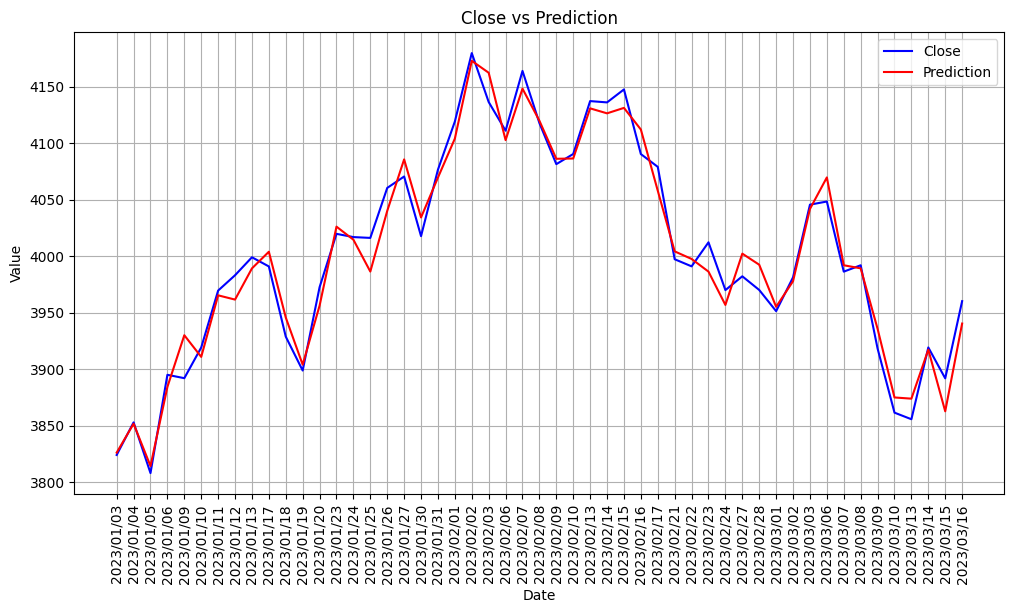

In [59]:
# drafting the line chart
plt.figure(figsize=(12, 6))

# Plotting the 'Close' values
plt.plot(df_predictions_pandas['Date'], df_predictions_pandas['Close'], label='Close', color='blue')

# Plotting the 'prediction' values
plt.plot(df_predictions_pandas['Date'], df_predictions_pandas['prediction'], label='Prediction', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Close vs Prediction')

plt.xticks(rotation=90)

plt.grid(True) 

# Adding legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()


To visualize each day on the x-axis, we adjust the script accordingly:

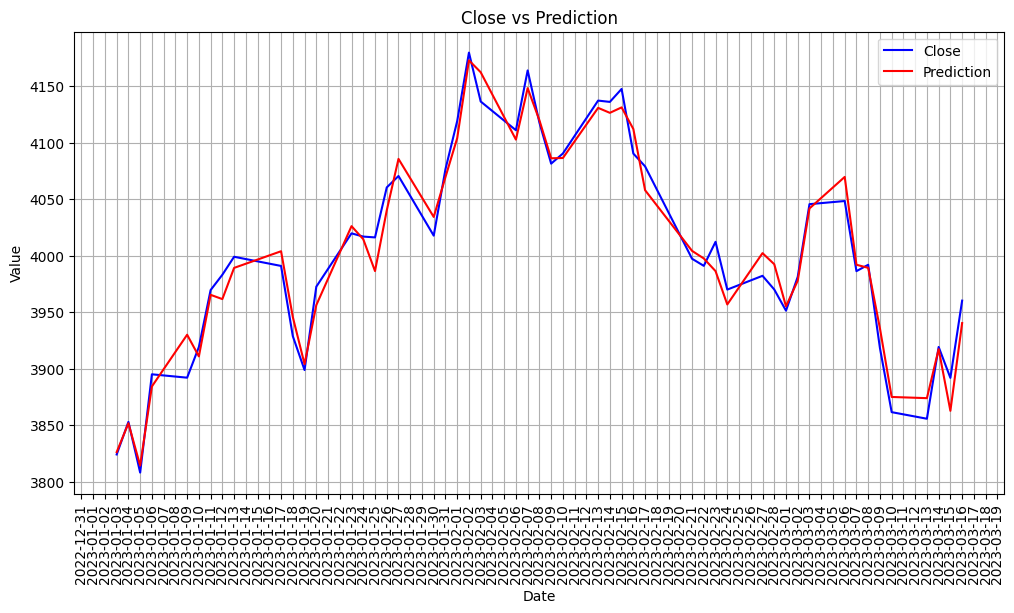

In [60]:
# Convert 'Date' column to datetime format
df_predictions_pandas['Date'] = pd.to_datetime(df_predictions_pandas['Date'])

# Optional: Set 'Date' as the index
# df_predictions_pandas.set_index('Date', inplace=True)

# Create the figure and set its size
plt.figure(figsize=(12, 6))

# Plotting the 'Close' and 'prediction' values
plt.plot(df_predictions_pandas['Date'], df_predictions_pandas['Close'], label='Close', color='blue')
plt.plot(df_predictions_pandas['Date'], df_predictions_pandas['prediction'], label='Prediction', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Close vs Prediction')

# Adjusting x-axis ticks for daily data
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Show every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format the date
plt.xticks(rotation=90)

plt.grid(True) 

# Adding legend
plt.legend()

# Show the plot
plt.show()


We can create a function to simplify the visualization of the chart with various start and end dates. Additionally, we can adjust the chart's title and size, especially when visualizing only a few days:

In [61]:
def draft_chart(from_date, end_date, title, chart_size):

    # Convert 'Date' column to datetime format if not already done
    df_predictions_pandas['Date'] = pd.to_datetime(df_predictions_pandas['Date'])

    # Filter the DataFrame for the specified date range
    start_date = from_date
    end_date = end_date
    mask = (df_predictions_pandas['Date'] >= start_date) & (df_predictions_pandas['Date'] <= end_date)
    filtered_df = df_predictions_pandas.loc[mask]

    # Create the figure and set its size
    if chart_size == "large_chart":
        plt.figure(figsize=(12, 6))
    elif chart_size == "small_chart":
        plt.figure(figsize=(6, 3))

    # Plotting the 'Close' and 'prediction' values for the filtered date range
    plt.plot(filtered_df['Date'], filtered_df['Close'], label='Close', color='blue')
    plt.plot(filtered_df['Date'], filtered_df['prediction'], label='Prediction', color='red')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)

    # Adjusting x-axis ticks for daily data
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Show every day
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format the date
    plt.xticks(rotation=75)

    plt.grid(True) 

    # Adding legend
    plt.legend()



As an example, we can use the function to focus solely on the data from January:

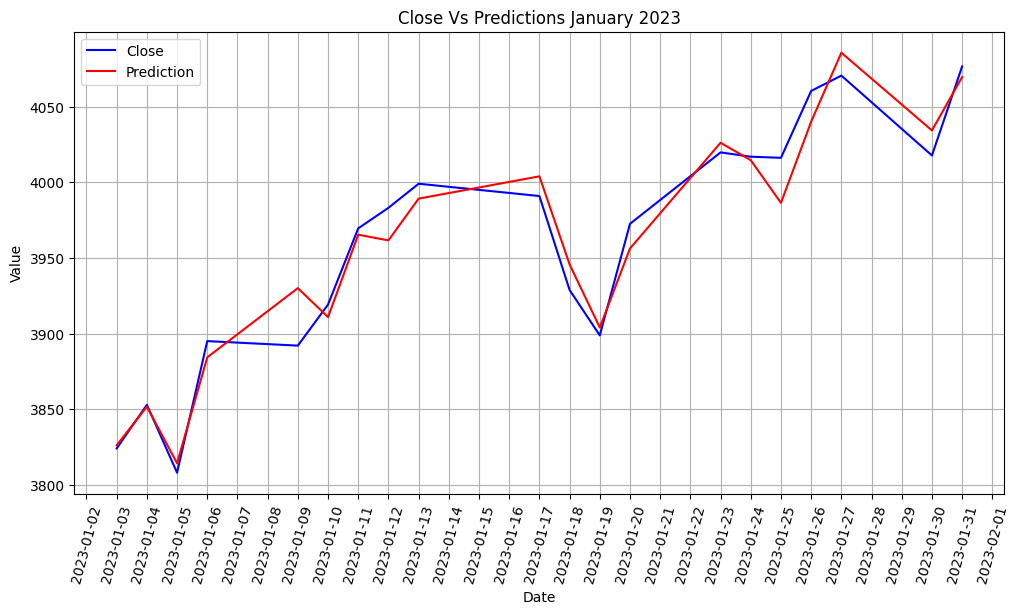

In [62]:
draft_chart('2023-01-01', '2023-01-31', 'Close Vs Predictions January 2023', "large_chart")

We can also take a closer look at the 'Close vs. Prediction' trend during specific time periods.

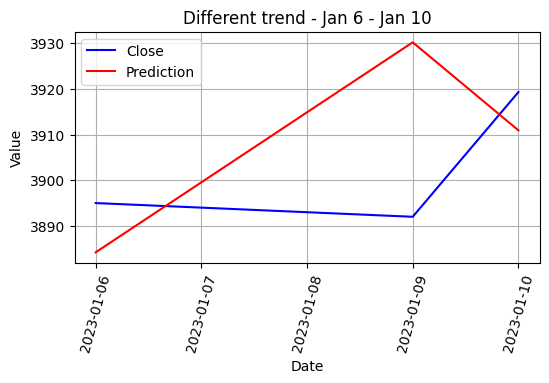

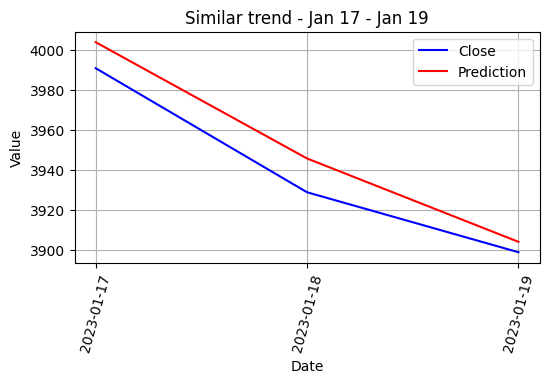

In [63]:
draft_chart('2023-01-06', '2023-01-10', 'Different trend - Jan 6 - Jan 10', 'small_chart')
draft_chart('2023-01-17', '2023-01-19', 'Similar trend - Jan 17 - Jan 19', 'small_chart')

The periods between January 6th - 10th and January 17th - 19th showcase two distinct trends in the line charts. During the January 6th - 10th period, the trends of the Close and Prediction lines diverge. In contrast, from January 17th - 19th, these trends align more closely. At this point, a financial analyst could investigate what might have influenced these two types of behavior.

In [64]:
# Stop Spark to free up resources
spark.stop()